## Increasing Computational Efficacy by Smarter Utilization of Memory Associated With Kernel Matrices
### Questions
- [ ] How do we update the cholesky factorization without computing an entirely new decomposition?

### Issues
- [ ] The final subroutine of computing covariances of fantasized gradients against other fantasized gradients needs to be checked. I believe the hessian computation has a sign error somewhere.
- Subroutine 7 has an issue with it's indices. I need to refactor the logic to support comparing the covariances of the current fantasized gradient sample against all previous fantasized gradient samples.

In [80]:
using DataFrames
using LinearAlgebra
using Plots

In [81]:
include("../rollout.jl")
include("../testfns.jl")
include("./CovarianceMatrix.jl")
include("../testfns.jl")

TestGramacyLee (generic function with 1 method)

In [82]:
m, h, d = 2, 2, 2
psm = PreallocatedSymmetricMatrix{Float64}(m, h, d)
X = rand(d, m+h+1)

2×5 Matrix{Float64}:
 0.0912212  0.202921  0.749763   0.0255131  0.941579
 0.634797   0.182654  0.0154861  0.795671   0.455833

In [83]:
# Construct covariance measure
θ = [1.]
ψ = kernel_matern52(θ);
σn2 = 1e-6

1.0e-6

## Building the Matrix via Subroutines

In [84]:
# Subroutine Order: 1, 2->3->4->5->8->6->7
Knews = []
# Subroutine number 1: Knowns against knowns
Kupdate = eval_KXX(ψ, X[:, 1:m]; σn2=σn2)
fKupdate = cholesky(Kupdate).U'
update_knowns!(psm, Kupdate)
cholesky_update_knowns!(psm, fKupdate)

for fndx in m+1:m+h+1
    # Subroutine number 2: Fantasized against knowns
    Kupdate = eval_KXY(ψ, X[:, fndx:fndx], X[:, 1:m])
    update_fantasized_vs_knowns!(psm, Kupdate, fndx)
       
    # Subroutine number 3: Fantasized against fantasized
    Kupdate = eval_KXX(ψ, X[:, m+1:fndx]; σn2=σn2)
    update_fantasized_vs_fantasized!(psm, Kupdate, fndx)
    
    # 4+5 Simultaneously
    # Subroutine number 4: Fantasized gradients against knowns
    # Subroutine number 5: Fantasized gradients against fantasized gradients
    Kupdate = eval_∇KxX(ψ, X[:, fndx], X[:, 1:fndx])
    update_gradfantasized_vs_fantasized_and_known!(psm, Kupdate, fndx-m) # (fndx - m)th grad
    
    # Subroutine number 8:
    if fndx-m > 1
        Kupdate = -eval_∇KxX(ψ, X[:, fndx], X[:, m+1:fndx-1])
        klength = size(Kupdate, 1) * size(Kupdate,2)
        Kupdate = reshape(Kupdate, klength)
        update_gradfantasized_vs_allprev_fantasized!(psm, Kupdate, fndx-m)
    end
    
    # # Subroutine number 6: Fantasized gradients against self fantasized gradients
    Kupdate = -eval_Hk(ψ, zeros(d))
    update_gradfantasized_vs_self!(psm, Kupdate, fndx-m)
    
    # Subroutine number 7: Fantasized gradients against other fantasized gradients
    Knews = []
    grad_ndx = fndx - m
    
    # Skip first gradient observation since previous fantasized values don't exist yet
    for j in 1:grad_ndx-1 # fndx-m computes the kth gradient ndx starting from 1
        Kn = -eval_Hk(ψ, X[:, fndx] - X[:, fndx - j])
        push!(Knews, Kn)
    end
    
    # Not sure why I needed to reverse here. Maybe it has to do with the Knews
    Knews = reverse(Knews)
    if fndx-m > 1
        Kupdate = Knews[1]
        for i = 2:length(Knews)
            Kupdate = hcat(Kupdate, Knews[i])
        end
        
        update_gradfantasized_vs_gradfantasized!(psm, Kupdate, fndx-m)
    end
end

In [89]:
clear_fantasized!(psm)

In [91]:
psm.K[]

11×11 Matrix{Float64}:
 1.0       0.848125  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.848125  1.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

# A Toy Example Problem

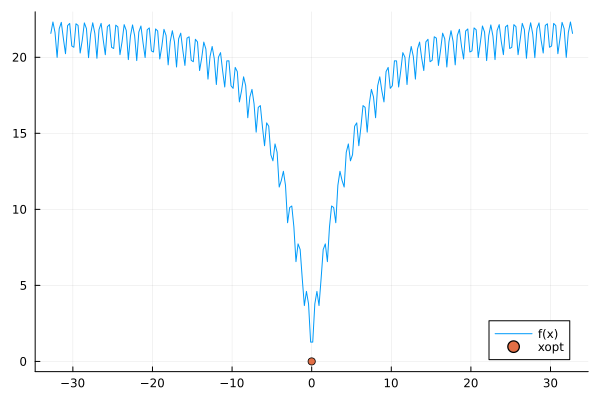

In [10]:
testfn = TestAckley(1)
tplot(testfn)

In [26]:
# Checking my logic for a single update to a cholesky factorization
Xcur = rand(2, 2)
Xupdate = hcat(Xcur, rand(2, 1))

Kcur = eval_KXX(ψ, Xcur)
Lcur = cholesky(Kcur).U'
Kupdate = eval_KXX(ψ, Xupdate)
Lupdate = cholesky(Kupdate).U'

l31 = Kupdate[3,1] / Lcur[1,1]
l32 = (Kupdate[3, 2] - l31*Lcur[2,1]) / Lcur[2,2]
l33 = sqrt(Kupdate[3,3] - l31^2 - l32^2)

Lother = [Lcur zeros(2, 1);
          l31 l32 l33]

@assert Lother ≈ Lupdate

In [32]:
Lupdate

3×3 LowerTriangular{Float64, Adjoint{Float64, Matrix{Float64}}}:
 1.0        ⋅          ⋅ 
 0.898869  0.438218    ⋅ 
 0.677909  0.0342372  0.734349